# Final model

I will go with **xgboost regressor** 
So I will use the entire data set to create model and create a pipeline to deploy the model
We need to create a pipeline including those phases to be able to make a prediction from row sql query text.
Pipeline step are:
- clean the query text
- use the tfidf vectorizer
- train model on the entire dataset

Then save the model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import sys
import pickle
import time

## Read data and remove outliers

In [2]:
df = pd.read_csv("./data/df_slow.csv")
summary = df["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
mask = (df["query_time_ns"]<summary["99%"])
sum(mask)

df = df[mask]

# X = df["clean_query"]
X = df["sql_text"]
y = df['query_time_ns']
print(df.shape, X.shape, y.shape)

(15375, 4) (15375,) (15375,)


In [3]:
def customize_text(text):
    def transform(t):
        t = t.lower()
        t = t.replace('\n', ' ').replace('\r', '')
        t = t.replace('\t', ' ')
        t = t.replace("/*", ' ')
        t = t.replace("2020.2.3", ' ')
        t = t.replace("*/", ' ')
        t = t.replace("*", ' star')
        t = re.sub(r"[',.;@#?!&$=())]+\ *", " ", t)
        t = t.replace("  ", ' ').strip()
        return t
    text = [transform(t) for t in text]
    return text

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def eval_model(model, x, y, data_type, prn = False):
    start = time.time()
    pred = model.predict(x)
    pred = np.exp(pred) - 1 
    pred_time = np.round((time.time() - start),4)
    if prn:
        print(f"{data_type} - Root mean squared error     : {(mean_squared_error(y, pred, squared=False)):.2f}")
        print(f"{data_type} - Mean absolute error         : {(mean_absolute_error(y, pred)):.2f}")
        print(f"{data_type} - Coefficient of determination: {(r2_score(y, pred)):.2f}")
        print(f"{data_type} - Time elapsed                : {pred_time}\n")
    return np.round(mean_squared_error(y, pred, squared=False),1), \
            np.round(mean_absolute_error(y, pred),1), \
            np.round(r2_score(y, pred),2), \
            pred_time


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [6]:
custom_text_transformer = FunctionTransformer(customize_text)

In [7]:
vectorizer = TfidfVectorizer()

In [8]:
from xgboost import XGBRegressor

In [9]:
max_depth = 2
min_child_weight = 2

In [10]:
pipe_xgb = Pipeline(steps=[
    ('preprocessor', custom_text_transformer),
    ('vectorizer', vectorizer),
    ('classifier', XGBRegressor(max_depth = max_depth, min_child_weight = min_child_weight)),
])
                            

To avoid negataive predictions at the production phase I applied a log transformation to **y** and exp transformation to **prediction**

In [11]:
z = np.log(1 + y)

In [12]:
pipe_xgb.fit(X,z)

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function customize_text at 0x00000233E7CD0E50>)),
                ('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=2, min_child_weight=2, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              v

In [13]:
pred = pipe_xgb.predict(X)
(pred)

array([ 4.6339703,  4.597088 ,  4.597088 , ...,  4.98147  ,  4.597088 ,
       12.004942 ], dtype=float32)

In [14]:
# inverse transform
pred = np.exp(pred) - 1 
pred

array([1.0192188e+02, 9.8195023e+01, 9.8195023e+01, ..., 1.4468840e+02,
       9.8195023e+01, 1.6356011e+05], dtype=float32)

In [15]:
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(pipe_xgb,  X, y, data_type="Train", prn = True)


Train - Root mean squared error     : 119872.75
Train - Mean absolute error         : 42361.00
Train - Coefficient of determination: 0.98
Train - Time elapsed                : 0.4007



In [16]:
import joblib
joblib_pipe_xgb = "./models/pipe_xgb.sav"
joblib.dump(pipe_xgb, joblib_pipe_xgb)

['./models/pipe_xgb.sav']

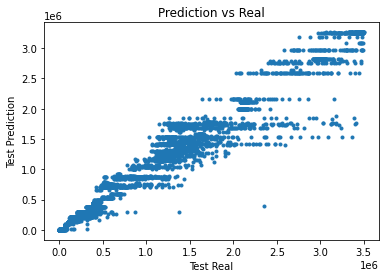

In [17]:
import matplotlib.pyplot as plt
plt.plot(figsize=(10,5))
plt.plot(y, pred, ".")
plt.title("Prediction vs Real")
plt.xlabel("Test Real")
plt.ylabel("Test Prediction")
plt.show()

In [18]:
query_text = ['/* ApplicationName=DataGrip 2020.2.3 */ select * from mysql.slow_log order by start_time desc']
pred_z = pipe_xgb.predict(query_text)
pred_y = np.exp(pred_z) - 1 
print(f"Query text              : {query_text}")
print(f"Predicted query time    : {pred_y[0]:.2f}")

Query text              : ['/* ApplicationName=DataGrip 2020.2.3 */ select * from mysql.slow_log order by start_time desc']
Predicted query time    : 163560.11


In [19]:
query_text = ["SELECT *"]
pred_z = pipe_xgb.predict(query_text)
pred_y = np.exp(pred_z) - 1 
print(f"Query text              : {query_text}")
print(f"Predicted query time    : {pred_y[0]:.2f}")

Query text              : ['SELECT *']
Predicted query time    : 306.19
